<a href="https://colab.research.google.com/github/ipgromov/machine_learning_project_attachments/blob/master/MLBP2018_Project_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Machine Learning Basic Principles 2018 - Data Analysis Project Report**

*All the text in italics is instructions for filling the template - remove when writing the project report!*

# *Title* 

*Title should be concise and informative, describes the approach to solve the problem. Some good titles from previous years:*

*- Comparing extreme learning machines and naive bayes’ classifier in spam detection*

*- Using linear discriminant analysis in spam detection*

*Some not-so-good titles:*

*- Bayesian spam filtering with extras*

*- Two-component classifier for spam detection*

*- CS-E3210 Term Project, final report*




## Abstract

*Precise summary of the whole report, previews the contents and results. Must be a single paragraph between 100 and 200 words.*



## 1. Introduction

*Background, problem statement, motivation, many references, description of
contents. Introduces the reader to the topic and the broad context within which your
research/project fits*

*- What do you hope to learn from the project?*
*- What question is being addressed?*
*- Why is this task important? (motivation)*

*Keep it short (half to 1 page).*



## 2. Data analysis

*Briefly describe data (class distribution, dimensionality) and how will it affect
classification. Visualize the data. Don’t focus too much on the meaning of the features,
unless you want to.*

*- Include histograms showing class distribution.*



The following code cells provide connection to the Kaggle account and download the datafiles to the "kaggle_data" directory of this notebook *(to be deleted later - only needed for Googe Colab)*.


In [5]:
# Install Kaggle package to the environment to access the data through the API
!pip install kaggle

    100% |████████████████████████████████| 61kB 2.3MB/s 
    100% |████████████████████████████████| 235kB 5.3MB/s 
  Running setup.py bdist_wheel for kaggle ... - done
  Stored in directory: /root/.cache/pip/wheels/44/2c/df/22a6eeb780c36c28190faef6252b739fdc47145fd87a6642d4
  Running setup.py bdist_wheel for python-slugify ... - done
  Stored in directory: /root/.cache/pip/wheels/e3/65/da/2045deea3098ed7471eca0e2460cfbd3fdfe8c1d6fa6fcac92
Successfully built kaggle python-slugify


In [6]:
# Setting API credentials (shouldn't be done this way - really unsafe in reality)
%env KAGGLE_USERNAME=addableowl
%env KAGGLE_KEY=640cd50ab6f85b9166403e039ba662d0

env: KAGGLE_USERNAME=addableowl
env: KAGGLE_KEY=640cd50ab6f85b9166403e039ba662d0


In [7]:
# Downloading and unzipping the data files
!kaggle competitions download -c mlbp-data-analysis-challenge-accuracy-2018 -f test_data.csv -p kaggle_data
!unzip kaggle_data/test_data.csv.zip -d kaggle_data
!kaggle competitions download -c mlbp-data-analysis-challenge-accuracy-2018 -f train_data.csv -p kaggle_data
!unzip kaggle_data/train_data.csv.zip -d kaggle_data
!kaggle competitions download -c mlbp-data-analysis-challenge-accuracy-2018 -f train_labels.csv -p kaggle_data

  0% 0.00/4.87M [00:00<?, ?B/s]
100% 4.87M/4.87M [00:00<00:00, 117MB/s]
Archive:  kaggle_data/test_data.csv.zip
  inflating: kaggle_data/test_data.csv  
  0% 0.00/3.25M [00:00<?, ?B/s]
100% 3.25M/3.25M [00:00<00:00, 155MB/s]
Archive:  kaggle_data/train_data.csv.zip
  inflating: kaggle_data/train_data.csv  
  0% 0.00/8.61k [00:00<?, ?B/s]
100% 8.61k/8.61k [00:00<00:00, 3.65MB/s]


Now we finally move to getting hands on the data!


In [0]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
# Load the data
train_df = pd.read_csv('kaggle_data/train_data.csv', header=None)
train_labels = pd.read_csv('kaggle_data/train_labels.csv', header=None)
test_df = pd.read_csv('kaggle_data/test_data.csv', header=None)

The feature space of the dataset is represented on this figure:
![alt text](https://github.com/ipgromov/Machine-Learning-Project/blob/master/images/feature_space.png?raw=true)
The feature extraction proccess is described below:
![alt text](https://github.com/ipgromov/Machine-Learning-Project/blob/master/images/feature_extraction.png?raw=true)

In [0]:
# Add artificially generated 'id' column

if 'id' not in train_df:
  train_df.insert(0, 'id', range(train_df.shape[0]))
train_df.set_index('id');

# Put ; in the end if you do not want to generate the output from the line of code

if 'id' not in train_labels:
  train_labels.insert(0, 'id', range(train_labels.shape[0]))
train_labels.set_index('id');

if 'id' not in test_df:
  test_df.insert(0, 'id', range(test_df.shape[0]))
test_df.set_index('id');

In [0]:
# Create a function that generates meaningful names for the columns
# The naming follows the pattern "component_part_statistic"

def generate_col_names():
  col_names = []
  components = {'Rhythm': (24, ('mean', 'median' , 'variance', 'kurtosis', 'skewness', 'min', 'max')), 'Chroma' : (12, ('mean', 'std', 'min', 'max')), 'MFCC' : (12, ('mean', 'std', 'min', 'max'))} 
  abbreviations = {'Rhythm': 'r', 'Chroma' : 'c', 'MFCC' : 'm'} 
  
  for component in components:
    for statistic in components[component][1]:
      for i in range(1, components[component][0] + 1):
        col_names.append('{}_{}_{}'.format(abbreviations[component], i, statistic))
  
  return col_names

In [0]:
# Call the function to get column names and then create a dictionary ( like 0 -> r_1_mean ... ) which can be used in df.rename method

col_names = generate_col_names()
col_names_dict = dict(zip(range(len(col_names)), col_names))

train_df = train_df.rename(col_names_dict, axis='columns')
test_df = test_df.rename(col_names_dict, axis='columns')

# Rename the column in train labels as 'gt' (short for groundtruth)

train_labels = train_labels.rename({0 : 'gt'}, axis='columns')

Observations about training data:

In [13]:
# Observe charachteristics of the features in the dataset

train_description = train_df.describe()
train_description

,id,r_1_mean,r_2_mean,r_3_mean,r_4_mean,r_5_mean,r_6_mean,r_7_mean,r_8_mean,r_9_mean,...,m_3_max,m_4_max,m_5_max,m_6_max,m_7_max,m_8_max,m_9_max,m_10_max,m_11_max,m_12_max
count,4363.000000,4363.000000,4363.000000,4363.000000,4363.000000,4363.000000,4363.000000,4363.000000,4363.000000,4363.000000,...,4363.000000,4363.000000,4363.000000,4363.000000,4363.000000,4363.000000,4363.000000,4363.000000,4363.000000,4363.000000
mean,2181.000000,3097.683714,4390.947408,3987.672465,4004.861996,3086.664978,3329.815872,3043.628357,3034.574066,2671.463266,...,0.148412,0.235156,0.099695,0.149826,0.079100,0.102965,0.070939,0.078456,0.070708,0.059353
std,1259.633942,1309.219331,1457.625815,1228.185868,1242.336635,1031.020501,1124.845689,1097.705493,1121.064034,1017.781965,...,0.053224,0.102935,0.038655,0.057284,0.026279,0.030300,0.020456,0.022035,0.026422,0.018123
min,0.000000,1.240000,3.565000,73.644000,147.370000,58.027000,136.670000,139.310000,157.260000,118.530000,...,-0.013915,-0.013511,-0.022156,-0.046172,0.003606,0.005359,0.003377,0.011343,0.005302,-0.007228
25%,1090.500000,2200.900000,3386.150000,3128.650000,3173.200000,2373.000000,2551.050000,2264.800000,2233.150000,1923.200000,...,0.111165,0.148390,0.070612,0.109415,0.061715,0.081870,0.056992,0.062765,0.051641,0.046992
50%,2181.000000,3114.600000,4376.800000,3988.500000,3976.300000,3041.300000,3276.400000,2960.900000,2956.800000,2601.600000,...,0.144030,0.225000,0.097368,0.146210,0.075773,0.101270,0.069202,0.077442,0.066268,0.057879
75%,3271.500000,3949.150000,5391.900000,4814.950000,4795.300000,3741.400000,4055.700000,3769.100000,3758.100000,3347.200000,...,0.180845,0.325125,0.123075,0.187625,0.092576,0.121835,0.083009,0.093005,0.085709,0.069603
max,4362.000000,9172.400000,9062.500000,8318.100000,9342.200000,8275.700000,8169.500000,7547.600000,8262.200000,8667.900000,...,0.383050,0.485230,0.301290,0.352410,0.246010,0.235600,0.195000,0.170010,0.182180,0.149770


In [0]:
# Export train_description as excel file

# !pip install openpyxl

# writer = pd.ExcelWriter('output.xlsx')
# train_description.to_excel(writer,'Sheet1')
# writer.save()

In [14]:
# Observe the fisrt five rows of the dataframe
train_df.head()

,id,r_1_mean,r_2_mean,r_3_mean,r_4_mean,r_5_mean,r_6_mean,r_7_mean,r_8_mean,r_9_mean,...,m_3_max,m_4_max,m_5_max,m_6_max,m_7_max,m_8_max,m_9_max,m_10_max,m_11_max,m_12_max
0,0,1040.7,2315.6,2839.1,2552.2,2290.4,1913.8,2152.6,1930.3,2079.3,...,0.216490,0.36548,0.093584,0.166870,0.083426,0.118090,0.089792,0.074371,0.073162,0.059463
1,1,2309.4,4780.4,4055.7,3120.5,1979.9,2343.6,2634.2,3208.5,3078.0,...,0.100670,0.14739,0.102560,0.213040,0.082041,0.080967,0.076450,0.052523,0.052357,0.055297
2,2,2331.9,4607.0,4732.3,5007.0,3164.9,3171.9,2915.7,3282.3,2400.0,...,0.126760,0.36321,0.114200,0.223780,0.100770,0.186910,0.067270,0.061138,0.085509,0.049422
3,3,3350.9,6274.4,5037.0,4609.7,3438.8,3925.8,3746.4,3539.4,3053.7,...,0.096479,0.28950,0.074124,0.201580,0.049032,0.130210,0.045800,0.080885,0.148910,0.042027
4,4,2017.6,3351.8,2924.9,2726.3,1979.9,1930.9,2083.4,1889.2,1695.4,...,0.138340,0.38266,0.079402,0.063495,0.053717,0.086750,0.062090,0.048999,0.033159,0.070813


In [15]:
# And the five last rows
train_df.tail()

,id,r_1_mean,r_2_mean,r_3_mean,r_4_mean,r_5_mean,r_6_mean,r_7_mean,r_8_mean,r_9_mean,...,m_3_max,m_4_max,m_5_max,m_6_max,m_7_max,m_8_max,m_9_max,m_10_max,m_11_max,m_12_max
4358,4358,3050.6,6570.7,5138.4,3620.7,3059.7,3909.8,3408.6,2232.5,2344.70,...,0.23154,0.28806,0.067744,0.094464,0.036829,0.091753,0.073977,0.102750,0.073559,0.059759
4359,4359,4356.6,2882.6,2349.8,2628.1,2838.8,3846.1,3490.6,3023.8,3023.50,...,0.16211,0.27834,0.110860,0.229430,0.091665,0.080436,0.083978,0.096520,0.080711,0.064529
4360,4360,2624.2,3688.7,2128.4,2318.7,1855.8,2002.8,1277.8,1391.8,1459.90,...,0.23888,0.28705,0.120680,0.200850,0.105450,0.082589,0.079226,0.065561,0.052131,0.080473
4361,4361,2751.0,3767.4,3858.7,6012.7,3201.4,3604.1,3332.9,3119.4,2464.10,...,0.11400,0.17835,0.139040,0.121960,0.068742,0.113470,0.076305,0.056053,0.042466,0.057299
4362,4362,4622.2,4410.2,2117.4,1533.8,1180.4,1164.3,1175.7,1005.4,906.58,...,0.07100,0.30119,0.057491,0.187630,0.080588,0.128700,0.036234,0.117810,0.098176,0.032360


Observations about train labels:

In [16]:
train_labels.describe()

,id,gt
count,4363.000000,4363.000000
mean,2181.000000,2.812056
std,1259.633942,2.500889
min,0.000000,1.000000
25%,1090.500000,1.000000
50%,2181.000000,2.000000
75%,3271.500000,4.000000
max,4362.000000,10.000000


In [17]:
train_labels.head()

,id,gt
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


In [18]:
train_labels.tail()

,id,gt
4358,4358,2
4359,4359,3
4360,4360,2
4361,4361,5
4362,4362,2


Observations about test data:

In [19]:
test_df.describe()

,id,r_1_mean,r_2_mean,r_3_mean,r_4_mean,r_5_mean,r_6_mean,r_7_mean,r_8_mean,r_9_mean,...,m_3_max,m_4_max,m_5_max,m_6_max,m_7_max,m_8_max,m_9_max,m_10_max,m_11_max,m_12_max
count,6544.000000,6544.000000,6544.000000,6544.000000,6544.000000,6544.000000,6544.000000,6544.000000,6544.000000,6544.00000,...,6544.000000,6544.000000,6544.000000,6544.000000,6544.000000,6544.000000,6544.000000,6544.000000,6544.000000,6544.000000
mean,3271.500000,3058.037015,4355.873590,3932.126318,3951.374646,3047.596245,3274.043362,3001.383570,2985.446799,2611.92090,...,0.149118,0.235902,0.098636,0.149432,0.078883,0.102099,0.070408,0.078485,0.070002,0.059404
std,1889.234413,1311.270031,1486.928587,1258.432257,1250.455530,1034.248602,1134.089032,1107.284447,1125.748255,1004.59801,...,0.053524,0.103901,0.037731,0.057528,0.025469,0.030438,0.020272,0.022191,0.026132,0.018306
min,0.000000,1.066000,1.066000,1.066000,1.066000,1.066000,1.066000,1.066000,1.066000,1.06600,...,-0.236350,-0.112690,-0.031280,-0.026286,0.003570,0.015833,-0.010660,0.012256,0.010891,0.001152
25%,1635.750000,2105.900000,3310.025000,3062.025000,3092.800000,2324.450000,2486.650000,2226.400000,2188.275000,1894.77500,...,0.112285,0.147525,0.069917,0.108408,0.061924,0.080391,0.056767,0.062885,0.051215,0.046886
50%,3271.500000,3090.150000,4327.800000,3922.100000,3924.350000,3009.050000,3210.000000,2925.000000,2903.350000,2546.55000,...,0.144455,0.225970,0.095175,0.146200,0.076156,0.100175,0.068897,0.077103,0.065160,0.057507
75%,4907.250000,3920.275000,5376.300000,4769.700000,4776.475000,3717.600000,3979.650000,3704.800000,3700.300000,3246.82500,...,0.180120,0.326053,0.120692,0.187967,0.092706,0.121443,0.083066,0.092811,0.083820,0.069989
max,6543.000000,9564.200000,9898.400000,9965.800000,8971.100000,7325.800000,8842.900000,8168.200000,8045.700000,8034.10000,...,0.379690,0.477750,0.317330,0.348470,0.259880,0.242150,0.178320,0.187250,0.180480,0.172850


In [20]:
test_df.head()

,id,r_1_mean,r_2_mean,r_3_mean,r_4_mean,r_5_mean,r_6_mean,r_7_mean,r_8_mean,r_9_mean,...,m_3_max,m_4_max,m_5_max,m_6_max,m_7_max,m_8_max,m_9_max,m_10_max,m_11_max,m_12_max
0,0,3115.5,3151.9,2742.2,3236.8,2580.6,2662.6,2372.2,2569.6,2310.7,...,0.202000,0.27811,0.138290,0.16759,0.106690,0.135000,0.087223,0.115030,0.074181,0.082354
1,1,2055.0,3225.7,2273.5,3601.9,1959.3,2212.3,1720.4,1640.4,1157.1,...,0.095165,0.17908,0.134300,0.14612,0.062988,0.113780,0.076223,0.105320,0.104750,0.067400
2,2,1601.2,3768.1,3591.0,3452.4,2935.9,2913.4,2479.6,2108.8,1823.8,...,0.114550,0.30952,0.096229,0.10636,0.037123,0.085613,0.051728,0.074393,0.047407,0.043231
3,3,2745.0,4585.8,4246.0,3937.6,3423.9,4108.2,3096.5,3469.6,3002.5,...,0.112300,0.42906,0.057022,0.16610,0.057594,0.127360,0.017878,0.075741,0.092060,0.028369
4,4,1515.0,2403.5,2461.6,2399.1,1999.4,2195.8,2123.0,2030.7,1737.4,...,0.098629,0.27692,0.057491,0.24435,0.039830,0.050223,0.045778,0.078015,0.067199,0.043448


In [21]:
test_df.tail()

,id,r_1_mean,r_2_mean,r_3_mean,r_4_mean,r_5_mean,r_6_mean,r_7_mean,r_8_mean,r_9_mean,...,m_3_max,m_4_max,m_5_max,m_6_max,m_7_max,m_8_max,m_9_max,m_10_max,m_11_max,m_12_max
6539,6539,5458.1,3816.1,2762.7,2198.3,1591.3,1135.3,758.03,1031.9,815.45,...,0.077645,0.21367,0.075442,0.079000,0.127220,0.099362,0.073899,0.040763,0.051660,0.064701
6540,6540,1597.6,2797.1,2198.8,1969.8,1889.4,2328.2,2289.20,2466.7,2086.00,...,0.266810,0.35590,0.131760,0.086360,0.078558,0.122500,0.060723,0.078580,0.027565,0.061399
6541,6541,1372.0,2186.0,1860.4,1932.1,1470.7,2403.0,2242.60,2227.6,2006.00,...,0.228130,0.23255,0.112530,0.074153,0.080115,0.055913,0.053767,0.052231,0.048352,0.036212
6542,6542,3921.2,4255.6,3193.0,4426.2,2868.7,3070.7,2640.00,2507.3,2229.40,...,0.108820,0.33653,0.096614,0.092141,0.074061,0.126560,0.058021,0.082832,0.076089,0.055648
6543,6543,1989.6,3771.4,3394.6,2957.2,2375.6,2747.8,2891.20,2420.2,2391.20,...,0.124550,0.11777,0.114480,0.189340,0.086654,0.104110,0.041426,0.071077,0.050447,0.059275


**The meanings of labels:**
1.  'Pop_Rock'
2.  'Electronic'
3.  'Rap'
4.  'Jazz'
5.  'Latin'
6.  'RnB'
7.  'International'
8.  'Country'
9.  'Reggae'
10. 'Blues'

In [22]:
# Count frequency of labels 1 to 10 in training dataset

# Almost as good as a histogram haha!

matrix_train_labels = train_labels.as_matrix()
#print(matrix_train_labels[:,1])

frequencies = []
for value in range(1, max(matrix_train_labels[:,1])+1):
  frequency = (matrix_train_labels[:,1]==value).sum()
  frequencies.append(frequency)
  
print(frequencies)


[2178, 618, 326, 253, 214, 260, 141, 195, 92, 86]


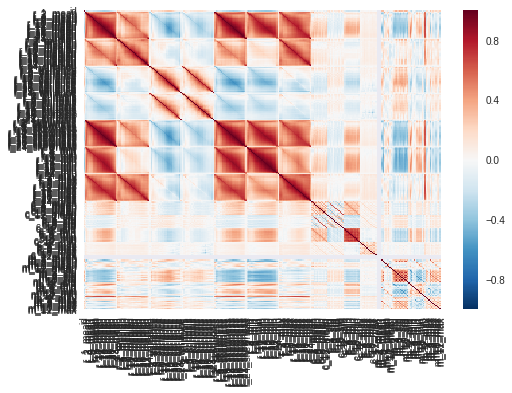

In [18]:
corr_mtrx = train_df.corr()
sns.heatmap(corr_mtrx)

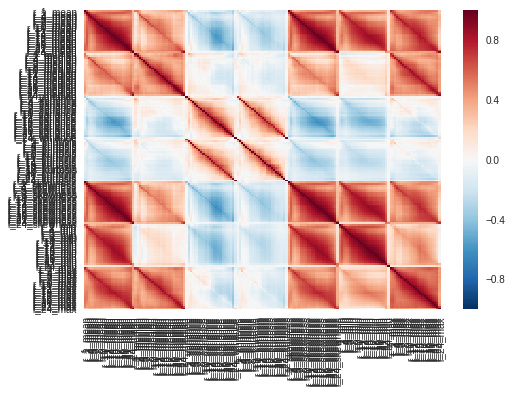

In [19]:
corr_mtrx_rhythm = train_df.iloc[:,1:169].corr()
sns.heatmap(corr_mtrx_rhythm)

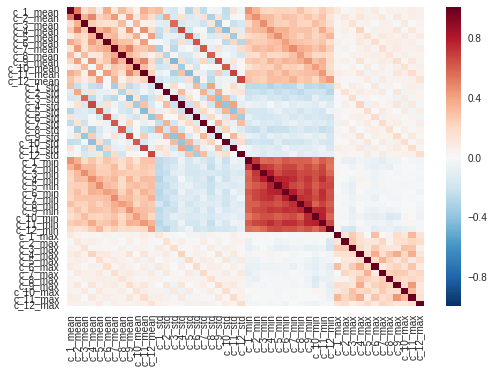

In [20]:
corr_mtrx_chroma = train_df.iloc[:,169:217].corr()
sns.heatmap(corr_mtrx_chroma)

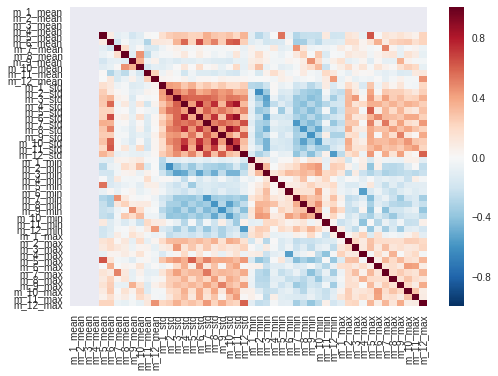

In [21]:
corr_mtrx_mfcc = train_df.iloc[:,217:265].corr()
sns.heatmap(corr_mtrx_mfcc)

Here I wrote my own splitting method, which I believe is redundant :( 

In [0]:
from random import sample

In [0]:
def split_data(data, percentage = 0.8):
  import numpy as np
  l = len(data) #length of data 
  f = round(percentage * l)  #number of elements you need
  indices = sample(range(l), f)
  
  train_data = data.iloc[indices]
  test_data = data.drop(data.index[indices])
  
  return train_data, test_data

In [0]:
local_train_df, local_test_df = split_data(data = train_df)

Here using the splitting method of scikit learn to split the data into training and  testing dataset

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(deletecolumns(train_df, ["id","m_1_mean","m_2_mean", "m_3_mean", "m_4_mean"]), train_labels['gt'], test_size=0.8, random_state=0)

In [0]:
def deletecolumns(data, column_no):
  reduced_data = data.drop(column_no, axis=1)
  return reduced_data;

In [79]:
train_df_deleted_errors = deletecolumns(train_df, ["id","m_1_mean","m_2_mean", "m_3_mean", "m_4_mean"])
test_df_deleted_errors = deletecolumns(test_df, ["id","m_1_mean","m_2_mean", "m_3_mean", "m_4_mean"])
train_df_deleted_errors.head()

,r_1_mean,r_2_mean,r_3_mean,r_4_mean,r_5_mean,r_6_mean,r_7_mean,r_8_mean,r_9_mean,r_10_mean,...,m_3_max,m_4_max,m_5_max,m_6_max,m_7_max,m_8_max,m_9_max,m_10_max,m_11_max,m_12_max
0,1040.7,2315.6,2839.1,2552.2,2290.4,1913.8,2152.6,1930.3,2079.3,1706.7,...,0.216490,0.36548,0.093584,0.166870,0.083426,0.118090,0.089792,0.074371,0.073162,0.059463
1,2309.4,4780.4,4055.7,3120.5,1979.9,2343.6,2634.2,3208.5,3078.0,3374.7,...,0.100670,0.14739,0.102560,0.213040,0.082041,0.080967,0.076450,0.052523,0.052357,0.055297
2,2331.9,4607.0,4732.3,5007.0,3164.9,3171.9,2915.7,3282.3,2400.0,1895.2,...,0.126760,0.36321,0.114200,0.223780,0.100770,0.186910,0.067270,0.061138,0.085509,0.049422
3,3350.9,6274.4,5037.0,4609.7,3438.8,3925.8,3746.4,3539.4,3053.7,3075.4,...,0.096479,0.28950,0.074124,0.201580,0.049032,0.130210,0.045800,0.080885,0.148910,0.042027
4,2017.6,3351.8,2924.9,2726.3,1979.9,1930.9,2083.4,1889.2,1695.4,1911.7,...,0.138340,0.38266,0.079402,0.063495,0.053717,0.086750,0.062090,0.048999,0.033159,0.070813


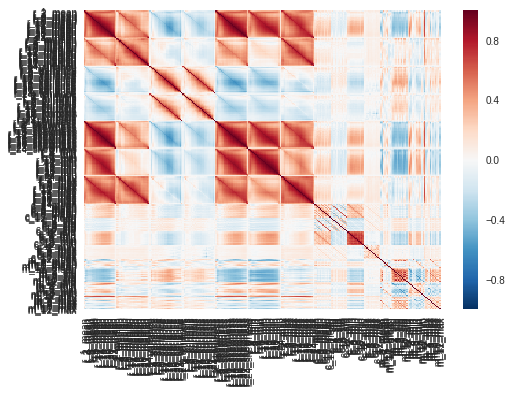

In [31]:
corr_mtrx_deleted_errors = train_df_deleted_errors.corr()
sns.heatmap(corr_mtrx_deleted_errors)

,c_1_min,c_2_min,c_3_min,c_4_min,c_5_min,c_6_min,c_7_min,c_8_min,c_9_min,c_10_min,c_11_min,c_12_min
c_1_min,1.000000,0.713624,0.565404,0.582934,0.559034,0.610818,0.587778,0.595229,0.588109,0.519618,0.605536,0.548046
c_2_min,0.713624,1.000000,0.711584,0.682606,0.609606,0.666597,0.670829,0.597234,0.649343,0.589437,0.664841,0.531792
c_3_min,0.565404,0.711584,1.000000,0.788263,0.654385,0.704381,0.711055,0.648509,0.664763,0.637546,0.684345,0.577239
c_4_min,0.582934,0.682606,0.788263,1.000000,0.772296,0.763390,0.741054,0.659193,0.717294,0.639272,0.741528,0.645833
c_5_min,0.559034,0.609606,0.654385,0.772296,1.000000,0.773961,0.665987,0.629431,0.690317,0.595837,0.679451,0.663421
c_6_min,0.610818,0.666597,0.704381,0.763390,0.773961,1.000000,0.786903,0.673682,0.727668,0.627940,0.741654,0.628670
c_7_min,0.587778,0.670829,0.711055,0.741054,0.665987,0.786903,1.000000,0.741463,0.718000,0.651119,0.733012,0.637028
c_8_min,0.595229,0.597234,0.648509,0.659193,0.629431,0.673682,0.741463,1.000000,0.762910,0.588868,0.673919,0.599380
c_9_min,0.588109,0.649343,0.664763,0.717294,0.690317,0.727668,0.718000,0.762910,1.000000,0.753479,0.758089,0.640477
c_10_min,0.519618,0.589437,0.637546,0.639272,0.595837,0.627940,0.651119,0.588868,0.753479,1.000000,0.777116,0.577237


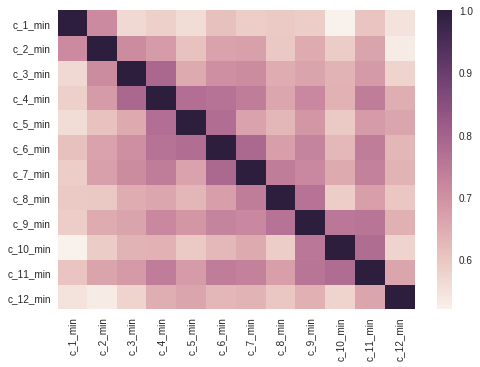

In [57]:
# observe data more - correlation of chroma min values 
corr_mtrx_chroma_min = train_df.iloc[:,193:205].corr()
sns.heatmap(corr_mtrx_chroma_min)
corr_mtrx_chroma_min


all the entries of that matrix are above 0.50 correlation

## 3. Methods and experiments

*- Explain your whole approach (you can include a block diagram showing the steps in your process).* 

*- What methods/algorithms, why were the methods chosen. *

*- What evaluation methodology (cross CV, etc.).*



In [0]:
# Importing the required libraries
import sklearn.linear_model as lm
import sklearn.metrics as metrics
import sklearn.tree as tree
import sklearn.svm as svm
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import cross_validate

In [0]:
# definition of functions that create submission files

# submission file for accuracy competition
def create_submission_accuracy(y_pred, filename):
  submission = np.vstack((np.array(range(1, len(y_pred)+1)), y_pred))
  submission_df = pd.DataFrame(submission.transpose(), columns=['Sample_id', 'Sample_label'])
  submission_df.to_csv(filename, index=False)

# submission file for logloss competition  
def create_submission_logloss(probas, filename):
  ids = np.array(range(1, probas.shape[0]+1)).reshape((probas.shape[0], 1))
  print(ids.shape, probas.shape)
  submission = np.append(ids, probas, axis=1)
  
  column_names = ['Sample_id']
  for i in range(10):
    column_names.append('Class_' + str(i+1))
    
  submission_df = pd.DataFrame(submission, columns=column_names)
  submission_df["Sample_id"] = submission_df["Sample_id"].astype("int32")
  submission_df.to_csv(filename, index=False)

In [0]:
# Trying out basic logistic regression
lr = lm.LogisticRegression()

In [0]:
cv_results = cross_validate(lr, train_df_deleted_errors, train_labels['gt'], cv=3, return_train_score=False)
cv_results['test_score']

In [0]:
lr.fit(X=train_df_deleted_errors, y=train_labels['gt'])
y_pred_deleted_errors = lr.predict(deletecolumns(test_df, ["id","m_1_mean","m_2_mean", "m_3_mean", "m_4_mean"]))

In [75]:
train_df_red_deleted = reduce_dimension_LDA(train_df_deleted_errors)
# Create array of explained variance ratios 
lda = LDA(n_components=None)
train_df_lda = lda.fit_transform(train_df_deleted_errors, y=train_labels['gt']) 
lda_var_ratios = lda.explained_variance_ratio_
print(lda_var_ratios)

[0.35396401 0.21286238 0.1689985  0.06426638 0.05950202 0.05479378
 0.03677415 0.02667281 0.02216596]


In [0]:
# defining a function that 
def select_n_components(var_ratio, goal_var: float) -> int:
    # Set initial variance explained so far
    total_variance = 0.0
    
    # Set initial number of features
    n_components = 0
    
    # For the explained variance of each feature:
    for explained_variance in var_ratio:
        
        # Add the explained variance to the total
        total_variance += explained_variance
        
        # Add one to the number of components
        n_components += 1
        
        # If we reach our goal level of explained variance
        if total_variance >= goal_var:
            # End the loop
            break
            
    # Return the number of components
    return n_components

In [76]:
# we want to explain 99% of the variance with the reduced features
select_n_components(lda_var_ratios, 0.99)

9

LDA needs 9 features to explain 99% of the variance within the data

In [0]:
#try out logistic regression with data that first has been removed 4 columns and then used LDA with 99% variance explained
train_df_lda_099 = lda.fit_transform(train_df_deleted_errors, y=train_labels['gt'])
lr_lda = lm.LogisticRegression()
lr_lda.fit(X=train_df_lda_099, y=train_labels['gt'])
y_pred_lda_099 = lr_lda.predict(lda.transform(test_df_deleted_errors))
probas_lda_099 = lr_lda.predict_proba(lda.transform(test_df_deleted_errors))

In [95]:
probas_lda_099.shape[0]

6544

this approach scored approx 0.644 accuracy

In [123]:
create_submission_logloss(probas_lda_099, "probas_logistic_del_errors_lda_099.csv")

(6544, 1) (6544, 10)


In [0]:
create_submission_accuracy(y_pred_lda_099, "logistic_del_errors_lda_099.csv")

In [0]:
create_submission_accuracy(y_pred_deleted_errors, "logistic_deleted_errors.csv")

In [0]:
#try out decision trees with standard parameters
tree_classifier = tree.DecisionTreeClassifier()
tree_classifier.fit(train_df_deleted_errors, y=train_labels['gt'])
y_pred_tree = tree_classifier.predict(deletecolumns(test_df, ["id","m_1_mean","m_2_mean", "m_3_mean", "m_4_mean"]))

In [46]:
#cross validate decision tree
cv_results_tree = cross_validate(tree_classifier, train_df_deleted_errors, train_labels['gt'], cv=3, return_train_score=False)
cv_results_tree['test_score']

array([0.43925875, 0.44742268, 0.45141282])

cv_results_tree["test_score"] was: array([0.43925875, 0.44742268, 0.45141282])

In [0]:
#try out support vector machines
svm_classifier = svm.SVC()
svm_classifier.fit(train_df_deleted_errors, y=train_labels['gt'])
y_pred_svm = svm_classifier.predict(deletecolumns(test_df, ["id","m_1_mean","m_2_mean", "m_3_mean", "m_4_mean"]))

In [52]:
#cross validate svm
cv_results_svm = cross_validate(tree_classifier, train_df_deleted_errors, train_labels['gt'], cv=3, return_train_score=False)
cv_results_svm["test_score"]

array([0.44269046, 0.43505155, 0.44452102])

cv_results_svm["test_score"] was: array([0.44269046, 0.43505155, 0.44452102])


In [74]:
y_pred = lr.predict(local_test_df)
score = metrics.accuracy_score(train_labels['gt'][local_test_df['id']], y_pred)
score

0.7342497136311569

In [0]:
#definition of function that creates submission file for accuracy competition
def create_submission_accuracy(y_pred, filename):
  submission = np.vstack((np.array(range(1, len(y_pred)+1)), y_pred))
  submission_df = pd.DataFrame(submission.transpose(), columns=['Sample_id', 'Sample_label'])
  submission_df.to_csv(filename, index=False)
  
def create_submission_logloss(probas, filename):
  ids = np.array(range(1, probas.shape[0]+1)).reshape((probas.shape[0], 1))
  print(ids.shape, probas.shape)
  submission = np.append(ids, probas, axis=1)
  
  column_names = ['Sample_id']
  for i in range(10):
    column_names.append('Class_' + str(i+1))
    
  submission_df = pd.DataFrame(submission, columns=column_names)
  submission_df["Sample_id"] = submission_df["Sample_id"].astype("int32")
  submission_df.to_csv(filename, index=False)

In [27]:
#we should also try out feature selection which is different from dimensionality reduction
#dimensionality reduction creates new combinations of attributes while feature selection includes 
#only selected attributes without changing them

#feature selection with univariate selection
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import chi2, f_classif

#chi2 test does not work as it only can handle positive values 
#therefore choose another score function

#test = SelectKBest(score_func=chi2, k=4)
#fit = test.fit(train_df, train_labels["gt"])
#features = fit.transform(train_df)

selector = SelectPercentile(f_classif, percentile=10)
selected_feature_dataset = selector.fit_transform(train_df, train_labels["gt"])
print("shape of selected dataset: ", selected_feature_dataset.shape)

#TODO: implement all these selection / dimensionality reduction algorithms as functions

shape of selected dataset:  (4363, 27)


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [217 218 219 220] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [0]:
#feature selection with recursive feature elimination

In [0]:
#function definition of PCA to reduce dimensionality - should capture at least 95% of variance
def reduce_dimension(dataset):
  pca095 = PCA(n_components = 0.95)
  reduced_data = pca095.fit_transform(dataset)
  return reduced_data;

In [0]:
#function PCA to 15 features - was needed to transform the train_df also to 15 features as reduce_dimension's output
#for train_df was with 15 features
def reduce_dimension_15(dataset):
  pca15 = PCA(n_components = 15)
  reduced_data = pca15.fit_transform(dataset)
  return reduced_data;

In [0]:
#define function for linear discriminant analysis (LDA) which is a supervised dimensionality reduction method
#may be more suitable than PDA for a supervised estimator

def reduce_dimension_LDA(dataset):
  lda = LDA(n_components=5)
  reduced_data = lda.fit_transform(dataset, y=train_labels['gt'])  
  return reduced_data;

In [31]:
#try logistic regression with reduced dimensionality
lr_red = lm.LogisticRegression()
lr_red.fit(X=reduce_dimension(train_df), y=train_labels['gt'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [0]:
y_pred_red = lr_red.predict(reduce_dimension_15(test_df))


In [0]:
submission = np.vstack((np.array(range(1, len(y_pred_red)+1)), y_pred_red))
submission_df = pd.DataFrame(submission.transpose(), columns=['Sample_id', 'Sample_label'])
submission_df.to_csv('submission_red_new.csv', index=False)

Here I am trying the EXTRA SPECIAL method. First of all let's just try and run logistic regression on the groups of features separately.

In [0]:
rhythm_features_train_df = train_df_deleted_errors.iloc[:, 0:168]
chroma_features_train_df = train_df_deleted_errors.iloc[:, 168:216]
mfcc_features_train_df = train_df_deleted_errors.iloc[:, 216:260]

feature_separators = (0, 168, 216, 260)



```
Here are the results of LR cross-validation separately for the 3 groups
[0.56691833 0.57869416 0.5720193 ]
[0.51544269 0.51408935 0.51412819]
[0.56142759 0.57319588 0.54651964]
```



In [51]:
for i in range(len(feature_separators)-1):
#   lr.fit(X=train_df_deleted_errors[feature_separators[i]:feature_separators[i+1]], y=train_labels['gt'])
#   y_pred_deleted_errors = lr.predict(deletecolumns(test_df, ["id","m_1_mean","m_2_mean", "m_3_mean", "m_4_mean"])[feature_separators[i]:feature_separators[i+1]])
  
  cv_results = cross_validate(lr, train_df_deleted_errors.iloc[:,feature_separators[i]:feature_separators[i+1]], train_labels['gt'], cv=3, return_train_score=False)
  print(cv_results['test_score'])

[0.56691833 0.57869416 0.5720193 ]
[0.51544269 0.51408935 0.51412819]
[0.56142759 0.57319588 0.54651964]


In [0]:
class separate_classifier:

  def __init__(X, y, seps):
    self.X = X
    self.y = y
    self.seps = seps
    
  def fit():
    probas = []
    for i in range(len(feature_separators)-1):
      lr.fit(X=train_df_deleted_errors[feature_separators[i]:feature_separators[i+1]], y=train_labels['gt'])
      probas.append(lr.predict_proba(deletecolumns(test_df, ["id","m_1_mean","m_2_mean", "m_3_mean", "m_4_mean"])[feature_separators[i]:feature_separators[i+1]]))
    return probas
    
  def predict():
    return self.y_pred
 

In [0]:
X_train, X_test, y_train, y_test = train_test_split(deletecolumns(train_df, ["id","m_1_mean","m_2_mean", "m_3_mean", "m_4_mean"]), train_labels['gt'], test_size=0.8, random_state=0)

In [62]:
probas = []
for i in range(len(feature_separators)-1):
  lr.fit(X=X_train.iloc[:,feature_separators[i]:feature_separators[i+1]], y=y_train)
  probas.append(lr.predict_proba(X_test.iloc[:,feature_separators[i]:feature_separators[i+1]]))

SyntaxError: ignored

In [66]:
probas = np.array(probas)
print(probas.shape)

(3, 3491, 10)


## 4. Results

*Summarize the results of the experiments without discussing their implications.*

*- Include both performance measures (accuracy and LogLoss).*

*- How does it perform on kaggle compared to the train data.*

*- Include a confusion matrix.*



In [0]:
#Confusion matrix ...

## 5. Discussion/Conclusions

*Interpret and explain your results *

*- Discuss the relevance of the performance measures (accuracy and LogLoss) for
imbalanced multiclass datasets. *

*- How the results relate to the literature. *

*- Suggestions for future research/improvement. *

*- Did the study answer your questions? *



## 6. References

*List of all the references cited in the document*

## Appendix
*Any additional material needed to complete the report can be included here. For example, if you want to keep  additional source code, additional images or plots, mathematical derivations, etc. The content should be relevant to the report and should help explain or visualize something mentioned earlier. **You can remove the whole Appendix section if there is no need for it.** *

In [83]:
a = np.array([[1], [2], [3]])
b = np.array([[4, 7], [5, 8], [6, 9]])
print(a.shape, b.shape)
c = np.append(a, b, axis=1)
print(c, c.shape)

(3, 1) (3, 2)
[[1 4 7]
 [2 5 8]
 [3 6 9]] (3, 3)


In [0]:
shape